In [1]:
import re
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.api import qqplot

In [2]:
if os.path.exists('final.csv'):
    final = pd.read_csv('final.csv')
else:
    final = pd.DataFrame(columns=['operator', 'inout_travelling', 'network_type', 'rating',
       'calldrop_category', 'latitude', 'longitude', 'state_name', 'month', 'year'])

csv_files = glob.glob("Call_Datasets/*.csv")

In [3]:
with open ('files_appended.txt', 'r') as f:
    appended_files = [s.strip() for s in f.readlines()]
f.close()

with open ('files_appended.txt', 'a+') as f:
    for file in csv_files:
        file = file.replace('\\', '/')
        
        if file not in appended_files:
            temp = pd.read_csv(file)
            year = re.search(r'\d{4}', file)
            month = re.search(r'/(\w+)_M', file)
            temp['month'] = month.group(1)
            temp['year'] = year.group()
            final = pd.concat([final, temp])
            f.writelines(f'{file}\n')

f.close()
final.state_name.replace('Unnamed: 7', None, inplace=True)
final.network_type.replace('Unknown', None, inplace=True)
final.state_name.replace('Laccadives', 'Lakshadweep', inplace=True)
final.to_csv('final.csv', index=False)
final.head()

,operator,inout_travelling,network_type,rating,calldrop_category,latitude,longitude,state_name,month,year
0,BSNL,Outdoor,2G,4,Satisfactory,-1.0,-1.0,NaN,April,2022
1,RJio,Outdoor,4G,5,Satisfactory,-1.0,-1.0,NaN,April,2022
2,RJio,Outdoor,4G,4,Satisfactory,-1.0,-1.0,NaN,April,2022
3,RJio,Outdoor,4G,3,Satisfactory,-1.0,-1.0,NaN,April,2022
4,RJio,Indoor,NaN,4,Satisfactory,-1.0,-1.0,NaN,April,2022


In [16]:
temp = final[(final.state_name.notna()) | (final.network_type.notna())]

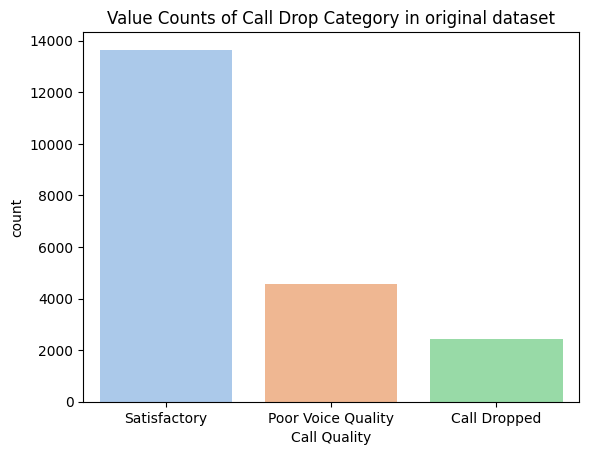

In [17]:
sns.countplot(data=final, x='calldrop_category', palette='pastel')
plt.xlabel('Call Quality')
plt.title('Value Counts of Call Drop Category in original dataset')
plt.xlabel('Call Quality')
plt.show()

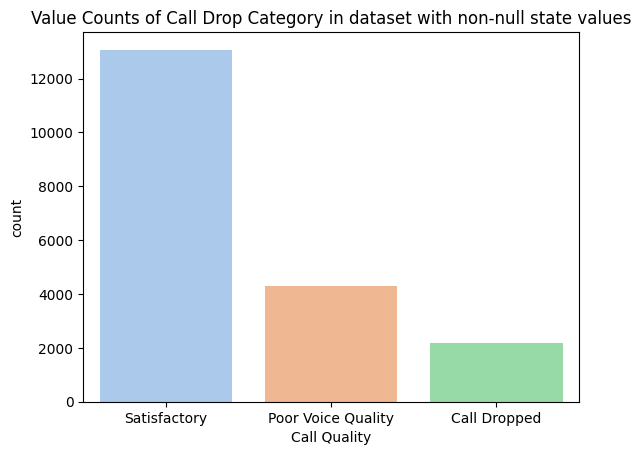

In [18]:
sns.countplot(data=temp, x='calldrop_category', palette='pastel')
plt.xlabel('Call Quality')
plt.title('Value Counts of Call Drop Category in dataset with non-null state values')
plt.xlabel('Call Quality')
plt.show()

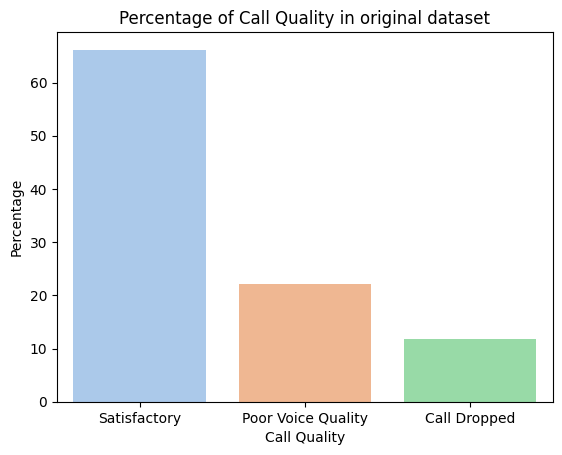

In [19]:
call_counts = final.calldrop_category.value_counts()
percent_call_counts = call_counts/len(final) * 100
sns.barplot(x=percent_call_counts.index, y=percent_call_counts, palette='pastel')
plt.xlabel('Call Quality')
plt.ylabel('Percentage')
plt.title('Percentage of Call Quality in original dataset')
plt.show()

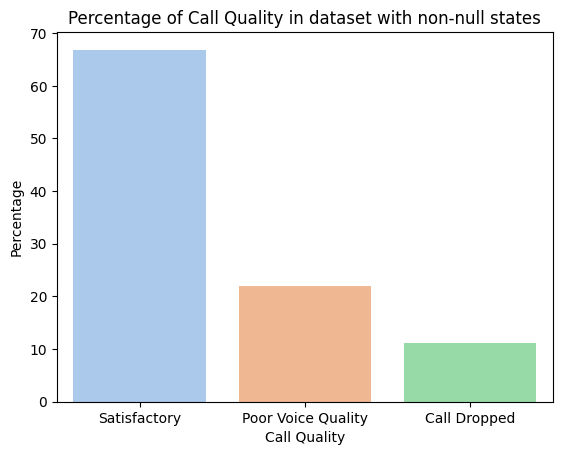

In [20]:
call_counts = temp.calldrop_category.value_counts()
percent_call_counts = call_counts/len(temp) * 100
sns.barplot(x=percent_call_counts.index, y=percent_call_counts, palette='pastel')
plt.xlabel('Call Quality')
plt.ylabel('Percentage')
plt.title('Percentage of Call Quality in dataset with non-null states')
plt.show()

In [21]:
num_col = temp.select_dtypes(include='number').columns.to_list()
obj_col = temp.select_dtypes(include='object').columns.to_list()

In [22]:
for col in num_col:
    result = f_oneway(*[temp[col][temp.calldrop_category == category] for category in temp.calldrop_category.unique()])
    print(f'Anova Result for {col} vs Call Drop')
    print('P-value: ', result.pvalue)
    print()
    

Anova Result for rating vs Call Drop
P-value:  0.0

Anova Result for latitude vs Call Drop
P-value:  1.5371018854472598e-276

Anova Result for longitude vs Call Drop
P-value:  0.0

Anova Result for year vs Call Drop
P-value:  1.1515267611701673e-41



In [24]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20632 entries, 0 to 20631
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   operator           20632 non-null  object 
 1   inout_travelling   20632 non-null  object 
 2   network_type       17144 non-null  object 
 3   rating             20632 non-null  int64  
 4   calldrop_category  20632 non-null  object 
 5   latitude           20632 non-null  float64
 6   longitude          20632 non-null  float64
 7   state_name         11490 non-null  object 
 8   month              20632 non-null  object 
 9   year               20632 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.6+ MB


In [25]:
for col in obj_col:
    cross_table = pd.crosstab(temp[col], temp.calldrop_category)
    print("Cross-Tabulation: ")
    print(cross_table)
    chi2, p, _, _ = chi2_contingency(cross_table)
    print("\nChi-Square Test:")
    print(f"Chi2 Value: {chi2}")
    print(f"P-value: {p}")
    print('*'*100)
    print()


Cross-Tabulation: 
calldrop_category  Call Dropped  Poor Voice Quality  Satisfactory
operator                                                         
Airtel                      324                1015          2969
BSNL                        566                 342           681
MTNL                          0                   0             1
RJio                        908                2231          4925
VI                          365                 728          4497

Chi-Square Test:
Chi2 Value: 1680.2439297571468
P-value: 0.0
****************************************************************************************************

Cross-Tabulation: 
calldrop_category  Call Dropped  Poor Voice Quality  Satisfactory
inout_travelling                                                 
Indoor                     1575                2917          8669
Outdoor                     487                1045          3190
Travelling                  101                 354          1214

Chi-S